In [1]:
import sys
sys.path.append("/home/anonymous/ECAP/nyx/")

In [2]:
import jax.numpy as jnp
import numpy as np
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.constants import c, h, k_B
from astropy.utils.data import download_file
from sklearn.neighbors import BallTree

from nyx.core.scene import ComponentType
from nyx.core import get_wavelengths, get_healpix_nside
from nyx.core import CatalogQuery, ParameterSpec
from nyx.core.model import EmitterProtocol
from nyx.atmosphere import get_airmass_formula

from nyx.core.spectral import Bandpass

# Figuring out stellar emitter

In [3]:
class GaiaDR3(EmitterProtocol):   
    def __init__(self):
        # Download catalog
        catalog_file = download_file('https://zenodo.org/records/15396676/files/gaiadr3.npy', cache=True)
        catalog = np.load(catalog_file)

        self.catalog = catalog
        # Get Bandpass
        G  = Bandpass.from_SVO('GAIA/GAIA3.G')
        BP = Bandpass.from_SVO('GAIA/GAIA3.Gbp')
        RP = Bandpass.from_SVO('GAIA/GAIA3.Grp')

        self.coords = SkyCoord(catalog['ra']*u.deg, catalog['dec']*u.deg, frame='icrs')
        
        # Build spatial index for efficient queries
        self.build_balltree()

    def build_balltree(self):
        self.balltree = BallTree(self.skycoord2localcoord(self.coords), metric='haversine')
        
    def skycoord2localcoord(self, skycoord):
        skycoord = skycoord.transform_to('icrs')
        return np.vstack([skycoord.spherical.lat.rad, skycoord.spherical.lon.rad]).T

    def query_fov(self, center_coord, radius):
        center_rad = self.skycoord2localcoord(center_coord)
        
        indices = self.balltree.query_radius(center_rad, radius)[0]
        return indices

    def get_generator(self, observation):       
        # Load global parameters
        wavelengths = get_wavelengths()
        nside = get_healpix_nside()

        # Query catalog
        star_indices = self.query_fov(observation.target, observation.fov.rad)
            
        # Get star data for FOV
        fov_stars = self.catalog[star_indices]
        fov_coords = self.coords[star_indices]
        
        # Transform to observation frame
        star_coords_altaz = fov_coords.transform_to(observation.AltAz)
        star_coords_image = star_coords_altaz.transform_to(observation.frame)
        
        # Calculate airmass
        airmass_func = get_airmass_formula()
        sec_Z = airmass_func(np.pi/2 - star_coords_altaz.alt.rad)
        
        # Get image coordinates
        image_coords = np.column_stack([
            star_coords_image.lon.rad,
            star_coords_image.lat.rad
        ])

        # Calculate flux for stars

        sec_Z = jnp.array(sec_Z)
        image_coords = jnp.array(image_coords)
        flux_values = jnp.array(flux_values)
        flux_map = jnp.array(flux_map_hemisphere)
        
        def generator(params):
            return CatalogQuery(
                sec_Z=sec_Z_jax,
                image_coords=image_coords_jax,
                flux_values=flux_values_jax * extinction_corr,
                flux_map=flux_map_jax * extinction_corr
            )
        
        param_specs = {
            'extinction_correction': ParameterSpec(
                (1,), 1.0, 
                description="Extinction correction factor",
                bounds=(0.1, 2.0)
            )
        }

        

        return fov_stars, fov_coords, sec_Z, image_coords, star_coords_altaz

In [4]:
import astropy
from astropy.coordinates import SkyCoord, Angle
from nyx.core import Observation

rotation = -0.25*u.deg
location = astropy.coordinates.EarthLocation.from_geodetic(16.5028, -23.27280, 1.8*u.km)
obstime  = astropy.time.Time('2021-06-04T21:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('sgr A*')
obs = Observation(location, obstime, target, rotation, fov=Angle(3*u.deg))

In [5]:
gaia = GaiaDR3()

In [6]:
%%time
fov_stars, fov_coords, sec_Z, image_coords, alti = gaia.get_generator(obs)

CPU times: user 241 ms, sys: 159 ms, total: 400 ms
Wall time: 400 ms


In [12]:
fov_coords.shape

(373712,)

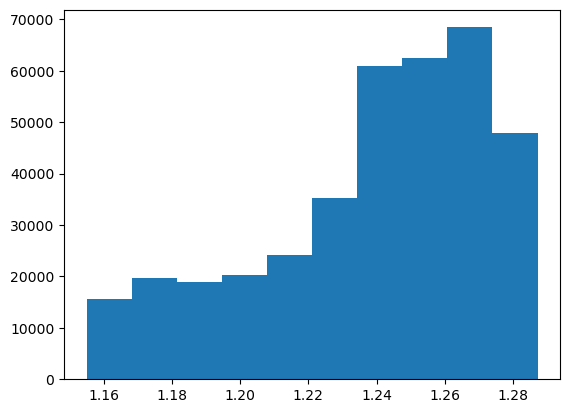

In [8]:
import matplotlib.pyplot as plt
h = plt.hist(sec_Z)